The code below should let us vizualise and see the matches.

In [4]:
import imageio
import supersuit as ss
from stable_baselines3 import PPO
from ctf_env import CaptureTheFlagPZ
import numpy as np

def record_match(red_model, blue_model, filename="match_replay.gif"):
    # 1. Setup Env with SAME wrappers as training
    env = CaptureTheFlagPZ(render_mode="rgb_array")
    
    # MUST match training wrappers
    # env = ss.resize_v1(env, x_size=84, y_size=84)
    # env = ss.color_reduction_v0(env, mode='full')
    # env = ss.frame_stack_v1(env, 3)
    
    observations, infos = env.reset()
    frames = []
    
    print(f"Recording match to {filename}...")
    
    # PettingZoo Loop
    while env.agents:
        # Save the full render (not the tiny agent view)
        # We access the internal env to get the full high-res map
        # Use env.unwrapped.render() to use our custom multi-agent visualizer
        frames.append(env.unwrapped.render())
        
        actions = {}
        # 2. Iterate through every agent currently in the game
        for agent_id in env.agents:
            obs = observations[agent_id]
            
            formatted_obs = {
                "image": np.array(obs["image"])[None, :],
                "role": np.array(obs["role"])[None, :]
            }
            
            if "red" in agent_id:
                act, _ = red_model.predict(formatted_obs, deterministic=True)
            else:
                act, _ = blue_model.predict(formatted_obs, deterministic=True)
            
            # predict returnerar en array [action], vi behöver värdet (int)
            actions[agent_id] = int(act[0])
            
        observations, rewards, terms, truncs, infos = env.step(actions)
    
    # Save GIF
    imageio.mimsave(filename, frames, fps=10)
    print(f"Replay saved! ({len(frames)} frames)")


Recording match to self_play_match.gif...
Replay saved! (800 frames)


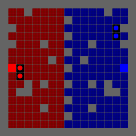

In [5]:
# --- RUN THE MATCH ---
# Load the model we just trained
# CRITICAL FIX: Added device="cpu"
champion_model = PPO.load("ctf_champion_100", device="cpu")

# Let the champion play against itself!
record_match(champion_model, champion_model, filename="self_play_match.gif")

from IPython.display import Image
display(Image(filename="self_play_match.gif"))

In [6]:
import time
import matplotlib.pyplot as plt
import supersuit as ss
import numpy as np
from IPython.display import clear_output, display
from ctf_env import CaptureTheFlagPZ

# --- 1. SETUP ENVIRONMENT ---
env = CaptureTheFlagPZ(render_mode="rgb_array")
# env = ss.resize_v1(env, x_size=84, y_size=84)
# env = ss.color_reduction_v0(env, mode='full')
# env = ss.frame_stack_v1(env, 3)

# --- 2. LIVE TOURNAMENT ---
wins = {"red": 0, "blue": 0, "draw": 0}
total_matches = 10

for i in range(total_matches):
    observations, _ = env.reset()
    step_count = 0
    
    # In PettingZoo ParallelEnv, the game ends when env.agents is empty
    while env.agents:
        # 1. Get AI Actions for ALL current agents
        actions = {}
        for agent_id in env.agents:
            obs = observations[agent_id]
            # Use the champion model for all agents
            formatted_obs = {
                "image": np.array(obs["image"])[None, :],
                "role": np.array(obs["role"])[None, :]
            }
        
            act, _ = champion_model.predict(formatted_obs, deterministic=False)
            actions[agent_id] = int(act[0])

        # 2. Step the Environment
        observations, rewards, terms, truncs, infos = env.step(actions)
        step_count += 1

        # 3. RENDER LIVE
        frame = env.unwrapped.render()
        
        plt.figure(figsize=(6,6))
        plt.imshow(frame)
        plt.axis('off')
        
        # Status Strings - Check if ANY agent on a team has the flag
        r_carrying = any(env.unwrapped.carrying_flag.get(f"red_{idx}", False) for idx in range(2))
        b_carrying = any(env.unwrapped.carrying_flag.get(f"blue_{idx}", False) for idx in range(2))
        
        r_status = "HAS FLAG!" if r_carrying else ""
        b_status = "HAS FLAG!" if b_carrying else ""
        
        title_str = (f"MATCH {i+1} / {total_matches}\n"
                     f"Red Team: {wins['red']} {r_status}  vs  Blue Team: {wins['blue']} {b_status}\n"
                     f"Step: {step_count}")
        plt.title(title_str, fontsize=12, fontweight='bold')
        
        plt.show()
        
        # --- SPEED CONTROL ---
        time.sleep(0.01) 
        clear_output(wait=True)
        
        # 4. Check Game Over and Results
        # If any agent terminated, we check the rewards to see who won
        if any(terms.values()) or any(truncs.values()):
            # Check team-wide rewards (if one red agent gets a high reward, red wins)
            red_reward = max([rewards.get(a, 0) for a in rewards if "red" in a] + [-1])
            blue_reward = max([rewards.get(a, 0) for a in rewards if "blue" in a] + [-1])

            if red_reward > 5.0:
                wins["red"] += 1
                print(f"Match {i+1} Result: RED TEAM CAPTURED THE FLAG!")
                time.sleep(2)
            elif blue_reward > 5.0:
                wins["blue"] += 1
                print(f"Match {i+1} Result: BLUE TEAM CAPTURED THE FLAG!")
                time.sleep(2)
            else:
                wins["draw"] += 1
                print(f"Match {i+1} Result: DRAW (Timeout)")
                time.sleep(1)
            break # Exit the while loop for this match


# --- FINAL RESULTS ---
print("="*30)
print("TOURNAMENT FINISHED")
print(f"Final Score: Red {wins['red']} - {wins['blue']} Blue")
print("="*30)

KeyboardInterrupt: 